In [35]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import community as community_louvain
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import json
import os

import pickle

In [36]:
# Load graph object from pickle file that we saved in lecture 4
DIRECTED_G = pickle.load(open('../data/graph.pickle', 'rb'))
UNDIRECTED_G = DIRECTED_G.copy().to_undirected()

In [37]:
def plot_network(graph):
    # Assigning a color to each community for visualization
    # community_colors = cm.rainbow(np.linspace(0, 1, len(communities)))

    # Create a dictionary to assign a color to each node based on its community
    # node_colors = {}
    # for community_index, community_nodes in enumerate(communities):
    #     for node in community_nodes:
    #         node_colors[node] = community_colors[community_index]


    # Visualize the graph with community colors
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)  # or use other layout algorithms like nx.kamada_kawai_layout
    nx.draw(graph, pos, 
            # node_color=[node_colors[node] for node in graph.nodes()], 
            edge_color='gray', style='solid', with_labels=False, node_size=5, font_size=8, width=0.2)
    plt.show()

# Community Detection

In [38]:
print(f"Size of graph BEFORE pruning - nodes: {UNDIRECTED_G.number_of_nodes()} & edges: {UNDIRECTED_G.number_of_edges()}")
UNDIRECTED_G = UNDIRECTED_G.subgraph(max(nx.connected_components(UNDIRECTED_G), key=len))
print(f"Size of graph AFTER pruning - nodes: {UNDIRECTED_G.number_of_nodes()} & edges: {UNDIRECTED_G.number_of_edges()}")

Size of graph BEFORE pruning - nodes: 16261 & edges: 24263
Size of graph AFTER pruning - nodes: 10219 & edges: 23428


## Louvain

In [39]:
def others_communities(communities, others):
    new_community = set()
    for j in others:
        new_community = new_community.union(communities[j])

    return [comm for i, comm in enumerate(communities) if i not in others] + [new_community]

In [40]:
df = pd.DataFrame(columns=["Resolution", "# Communities", "# Significant Communities", "Communities", "Node distribution", "Node distribution (%)", "Others (%)",
                           "Communities (with Others)","Initial modularity", "'Others' modularity"])

for i in range(10):
    # Apply the Louvain community detection algorithm
    resolution = 0 + (i*2)*0.1
    communities = louvain_communities(UNDIRECTED_G, resolution=resolution, seed=1234)
    communities = sorted([comm for comm in communities], key=len, reverse=True)
    len_communities = [len(comm) for comm in communities]
    percentages = [100*l/sum(len_communities) for l in len_communities]
    others = [i for i, el in enumerate(percentages) if el < 1]
    communities_others = others_communities(communities,  others)
    df.loc[len(df)] = {
        "Resolution": resolution,
        "# Communities": len(communities),
        "# Significant Communities": len([l/sum(percentages) for l in percentages if l > 1]),
        "Communities": communities,
        "Node distribution": len_communities,
        "Node distribution (%)": percentages,
        "Others (%)": sum([el for i, el in enumerate(percentages) if i in others]),
        "Communities (with Others)": communities_others,
        "Initial modularity": nx.community.modularity(UNDIRECTED_G, communities),
        "'Others' modularity": nx.community.modularity(UNDIRECTED_G, communities_others)
    }

In [41]:
df

,Resolution,# Communities,# Significant Communities,Communities,Node distribution,Node distribution (%),Others (%),Communities (with Others),Initial modularity,'Others' modularity
0,0.0,1,1,"[{Gauntlet Legends, Gunman Taco Truck, The Kin...",[10219],[100.0],0.000000,"[{Gauntlet Legends, Gunman Taco Truck, The Kin...",0.000000,0.000000
1,0.2,14,4,"[{Gunman Taco Truck, Half-Life 2: Episode Two,...","[5393, 2757, 1054, 724, 88, 54, 35, 29, 22, 19...","[52.77424405519131, 26.979156473236127, 10.314...",2.847637,"[{Gunman Taco Truck, Half-Life 2: Episode Two,...",0.542966,0.542530
2,0.4,20,12,"[{Gunman Taco Truck, Castlevania: Lords of Sha...","[2393, 1495, 1346, 846, 803, 695, 623, 579, 36...","[23.417164106076914, 14.62961150797534, 13.171...",2.886780,"[{Gunman Taco Truck, Castlevania: Lords of Sha...",0.726649,0.726162
3,0.6,29,17,"[{Castlevania: Lords of Shadow, Deathloop, Thi...","[1217, 1185, 847, 812, 764, 698, 640, 592, 564...","[11.909188766024073, 11.596046579900186, 8.288...",4.628633,"[{Castlevania: Lords of Shadow, Deathloop, Thi...",0.752621,0.751503
4,0.8,37,24,"[{Tarzan: Untamed, Xtreme Wheels, TimeSplitter...","[1099, 823, 759, 637, 625, 590, 559, 543, 485,...","[10.75447695469224, 8.053625599373715, 7.42734...",3.865349,"[{Tarzan: Untamed, Xtreme Wheels, TimeSplitter...",0.756568,0.755890
5,1.0,44,26,"[{Threes, Tarzan: Untamed, Mario Party 2, Fire...","[840, 694, 598, 580, 579, 525, 523, 503, 462, ...","[8.219982385752031, 6.791271161561797, 5.85184...",8.797338,"[{Threes, Tarzan: Untamed, Mario Party 2, Fire...",0.756648,0.752346
6,1.2,47,33,"[{Tarzan: Untamed, Mario Party 2, Mutant Night...","[814, 655, 588, 555, 535, 511, 491, 419, 379, ...","[7.965554359526372, 6.4096291222233095, 5.7539...",4.912418,"[{Tarzan: Untamed, Mario Party 2, Mutant Night...",0.757736,0.756687
7,1.4,70,32,"[{Tarzan: Untamed, Mario Party 2, Ninja JaJaMa...","[736, 595, 534, 510, 478, 406, 403, 399, 356, ...","[7.202270280849398, 5.822487523241022, 5.22556...",14.932968,"[{Tarzan: Untamed, Mario Party 2, Ninja JaJaMa...",0.756651,0.744335
8,1.6,64,40,"[{Tarzan: Untamed, Mario Party 2, Ninja JaJaMa...","[675, 512, 489, 463, 413, 378, 337, 303, 303, ...","[6.605342988550738, 5.01027497798219, 4.785204...",11.243762,"[{Tarzan: Untamed, Mario Party 2, Ninja JaJaMa...",0.754403,0.747280
9,1.8,76,39,"[{Fire Emblem: Path of Radiance, Mutant Night,...","[624, 408, 375, 355, 351, 318, 293, 288, 261, ...","[6.106272629415794, 3.9925628730795575, 3.6696...",20.090028,"[{Fire Emblem: Path of Radiance, Mutant Night,...",0.751168,0.726369


In [42]:
def to_percentage(l):
    return [100*el/sum(l) for el in l]

[11.909188766024073, 11.596046579900186, 8.288482238966631, 7.9459829728936295, 7.476269693707799, 6.830413934827282, 6.262843722477737, 5.793130443291907, 5.519131030433506, 5.166846071044134, 5.01027497798219, 4.344847832468931, 2.3094236226636657, 2.3094236226636657, 2.2115666894999513, 1.242783051179176, 1.1547118113318329, 0.8513553185243175, 0.841569625207946, 0.7632840786769742, 0.6458557588805167, 0.3327135727566298, 0.2544280262256581, 0.2544280262256581, 0.20549955964380076, 0.18592817301105782, 0.10764262648008611, 0.10764262648008611, 0.07828554653097172]


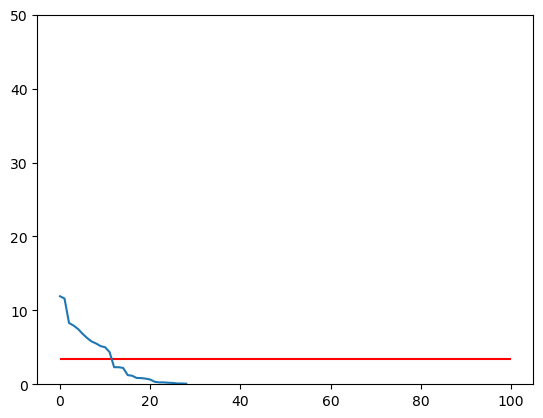

In [43]:
to_plot = df["Node distribution (%)"].iloc[3]
print(to_plot)
plt.hlines([np.average(to_plot)],[0],[100], colors=['red'])
plt.ylim(0,50)
plt.plot(range(len(to_plot)), to_plot)
plt.show()

In [44]:
print(f"Modularity: {nx.community.modularity(UNDIRECTED_G, communities)}")

Modularity: 0.7511677166130842


## Spectral Clustering

In [45]:
from sklearn.cluster import SpectralClustering
def spectral_clustering(graph, n_clusters = 10):
    # Convert the graph into an adjacency matrix
    adj_matrix = nx.to_numpy_array(graph)

    # Perform spectral clustering
    # In practice, this should be based on the specific characteristics of the graph.
    spectral_cluster = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral_cluster.fit_predict(adj_matrix)

    # Output the labels to see the community assignments
    return labels.tolist()

In [46]:
import collections
labels = spectral_clustering(UNDIRECTED_G, 10)
collections.Counter(labels)

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\PC-312\.conda\envs\sg_i\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\PC-312\.conda\envs\

Counter({0: 10119, 4: 10, 5: 6, 7: 17, 9: 6, 2: 14, 1: 6, 3: 25, 6: 5, 8: 11})

# Get Community Information

In [47]:
chosen = 3
communities = df["Communities (with Others)"].iloc[chosen]

In [48]:
# Others
communities[-1]

{'1001 Crystal Mazes Collection',
 '11-11: Memories Retold',
 '2nd Super Robot Wars OG',
 '4th Super Robot Wars',
 "A Witch's Tale",
 'Aikatsu Planet!',
 'Aikatsu Stars!',
 'Aikatsu!',
 'Aliens vs. Predator: Requiem (video game)',
 'Amazon Trail II',
 "Another Century's Episode",
 "Another Century's Episode 2",
 "Another Century's Episode 3: The Final",
 "Another Century's Episode Portable",
 "Another Century's Episode: R",
 'Asphalt 5',
 'Asphalt 6: Adrenaline',
 'Asphalt 7: Heat',
 'Asphalt 8: Airborne',
 'Asphalt 9: Legends',
 'Asphalt Xtreme',
 'Asphalt: Injection',
 'Astonishia Story',
 'Atomic Bomberman',
 'Atomix (video game)',
 'Avatar: The Game',
 'Ball Fighter',
 'Batman: Rise of Sin Tzu',
 'Battleground 5: Antietam',
 'Battleships Forever',
 'Beast (video game)',
 'Beat City',
 "Betty Boop's Double Shift",
 'Blood+',
 'Blue Lightning (1989 video game)',
 'Bombergirl',
 "Bomberman '93",
 "Bomberman '94",
 'Bomberman (Nintendo 3DS game)',
 'Bomberman 64 (1997 video game)',
 'B

In [49]:
def get_community_violence(community):
    nodes_in_community = (node for node in UNDIRECTED_G if node in community)
    sentiments = nx.get_node_attributes(UNDIRECTED_G, "sentiment")

    return [sentiments[node]['violence'] for node in nodes_in_community if node in sentiments]

In [50]:
from collections import Counter
def community_genre_analysis(community):
    nodes_in_community = [node for node in UNDIRECTED_G if node in community]
    genres = nx.get_node_attributes(UNDIRECTED_G, "genres")
    nodes_in_genre = [node for node in nodes_in_community if node in genres.keys()]
    flatten_genres = [g  for node in nodes_in_genre for g in genres[node]]
    counts = dict(Counter(flatten_genres))
    total = sum(counts.values())
    # total = len(nodes_in_genre)
    counts = sorted(counts.items(), key=lambda k: k[1], reverse=True)
    counts = [(i, 100*c/total) for i,c in counts]
    return counts

In [51]:
def get_in_degree(community):
    return [DIRECTED_G.in_degree(node) for node in community]
def get_out_degree(community):
    return [DIRECTED_G.out_degree(node) for node in community]
def get_degree(community):
    return [UNDIRECTED_G.degree(node) for node in community]

In [52]:
years = nx.get_node_attributes(UNDIRECTED_G, "year")

info = dict()
info["sentiment"] = {i: np.average(get_community_violence(comm)) for i,comm in enumerate(communities)}
info["sentiment_more"] = {i: get_community_violence(comm) for i,comm in enumerate(communities)}
info["year"] = {i: np.average([years[el] for el in comm if el in years]) for i,comm in enumerate(communities)}
info["year_more"] = {i: [years[el] for el in comm if el in years] for i,comm in enumerate(communities)}
info["genre"] = {i: community_genre_analysis(comm)  for i,comm in enumerate(communities)}
info["in_degree"] = {i: get_in_degree(comm)  for i,comm in enumerate(communities)}
info["out_degree"] = {i: get_out_degree(comm)  for i,comm in enumerate(communities)}

In [53]:
sorted_communities_by_year_indexes = [str(i) for i,_ in sorted(list(info["year"].items()), key=lambda x: x[1])]

In [54]:
def boxplot_communities(y,x, title, yscale = None):
    fig, ax = plt.subplots(figsize=(10,6))
    # Create a boxplot
    ax.boxplot(y, labels=x)

    # Add titles and labels
    ax.set_title(title)
    ax.set_ylabel('Values')
    ax.set_xlabel('Categories')
    if yscale != None:
        ax.set_yscale('log')
    # Show the plot
    fig.show()

## Year analysis

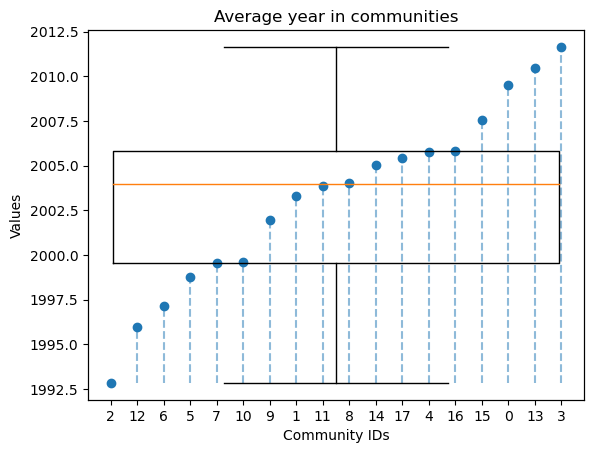

In [55]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Scatter plot
y = [info["year"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
ax1.scatter(x, y)

# Set the x-ticks to correspond to the scatter plot
ax1.set_xticks(x)
ax1.set_xticklabels(x)

# Adding titles and labels
ax1.set_title('Average year in communities')
ax1.set_ylabel('Values')
ax1.set_xlabel('Community IDs')

# Creating secondary x-axis for scatter plot
ax2 = ax1.twiny()

# Creating the boxplot
box_width = 0.9
ax2.boxplot(y, widths=box_width)

# Hide the original x-axis
ax2.set_xticks([])

# Drawing vertical, discontinuous lines from x-axis to each scatter point
for x_val, y_val in zip(x, y):
    ax1.vlines(x_val, ymin=min(y), ymax=y_val, linestyles='dashed', alpha=0.5)

plt.show()

C:\Users\PC-312\AppData\Local\Temp\ipykernel_20112\2245855642.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


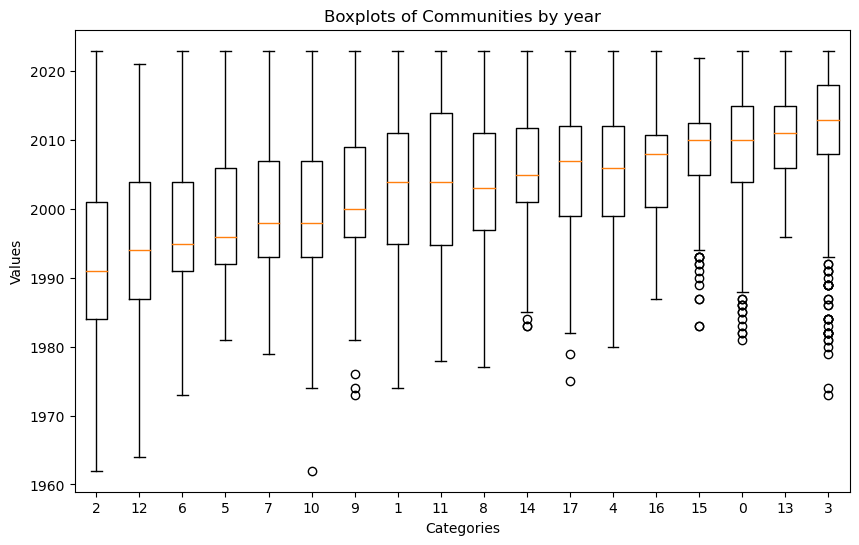

In [56]:
import matplotlib.pyplot as plt

# Prepare figure
# You can adjust the size as needed
y = [info["year_more"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
boxplot_communities(y,x, 'Boxplots of Communities by year')

In [57]:
from scipy import stats
def kruskal_wallis_test(*groups):
    """
    Perform the Kruskal-Wallis H Test
    :param groups: Variable number of lists, each representing a community's node degrees
    :return: Kruskal-Wallis H test result
    """
    stat, p_value = stats.kruskal(*groups)
    return stat, p_value

iter_list = [int(i) for i in sorted_communities_by_year_indexes]
results = pd.DataFrame(columns=['index'] + iter_list)
threshold = 0.05
for k, i in enumerate(iter_list):
    iteration = dict()
    iteration["index"] = i
    # for j in iter_list[0: (k+1)]:
    #     iteration[j] = "-"
    for j in iter_list[(k+1):len(iter_list)]:
        (stat, p_value) = kruskal_wallis_test(info['in_degree'][i], info['in_degree'][j])
        iteration[j] = "+" if p_value < threshold else " "
    results.loc[len(results)] = iteration

In [58]:
results

,index,2,12,6,5,7,10,9,1,11,8,14,17,4,16,15,0,13,3
0,2,NaN,+,+,+,+,,,+,+,,+,+,+,+,,+,+,
1,12,NaN,NaN,,,,+,+,,,+,,,,,+,,,+
2,6,NaN,NaN,NaN,+,,,,,,,,,+,,,+,,+
3,5,NaN,NaN,NaN,NaN,,+,+,,+,+,,,,,+,,,+
4,7,NaN,NaN,NaN,NaN,NaN,+,+,,,+,,,,,+,,,+
5,10,NaN,NaN,NaN,NaN,NaN,NaN,,+,,,+,+,+,,,+,+,
6,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,+,,,+,+,+,,,+,+,
7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,+,,,+,,,,,+
8,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,+,,,+,,+
9,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,+,+,,,+,+,


## By In-Degree

C:\Users\PC-312\AppData\Local\Temp\ipykernel_20112\2245855642.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


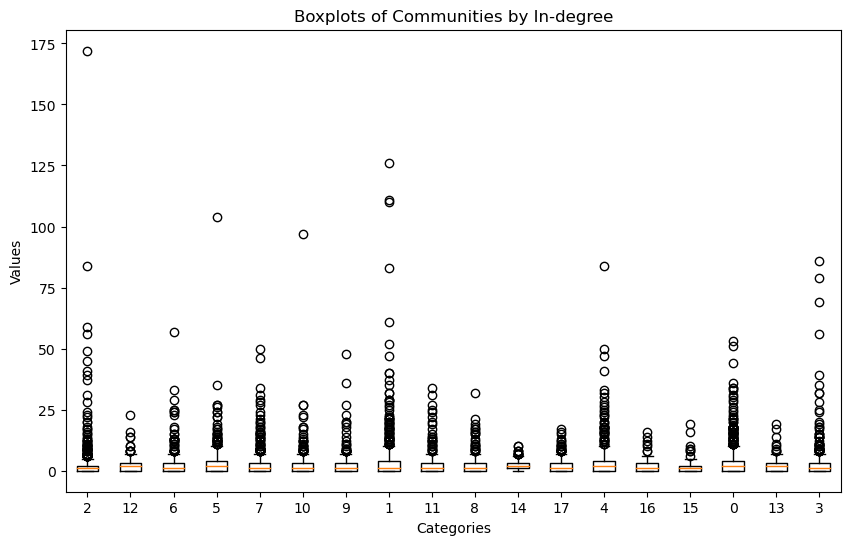

In [59]:
import math

y = [[d for d in info["in_degree"][int(i)]] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
boxplot_communities(y,x, 'Boxplots of Communities by In-degree')

## By Violence

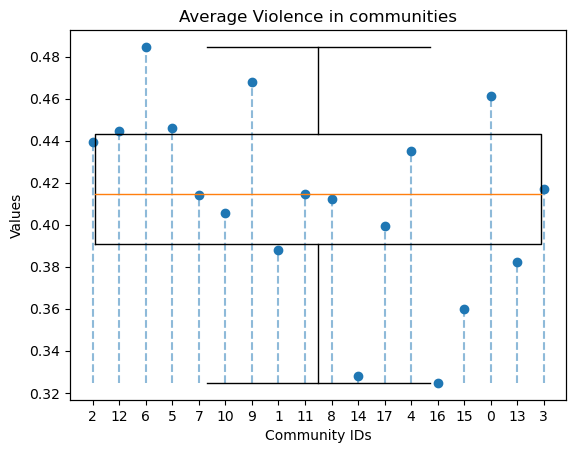

In [60]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Scatter plot
y = [info["sentiment"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
ax1.scatter(x, y)

# Set the x-ticks to correspond to the scatter plot
ax1.set_xticks(x)
ax1.set_xticklabels(x)

# Adding titles and labels
ax1.set_title('Average Violence in communities')
ax1.set_ylabel('Values')
ax1.set_xlabel('Community IDs')

# Creating secondary x-axis for scatter plot
ax2 = ax1.twiny()

# Creating the boxplot
box_width = 0.9
ax2.boxplot(y, widths=box_width)

# Hide the original x-axis
ax2.set_xticks([])

# Drawing vertical, discontinuous lines from x-axis to each scatter point
for x_val, y_val in zip(x, y):
    ax1.vlines(x_val, ymin=min(y), ymax=y_val, linestyles='dashed', alpha=0.5)

plt.show()

C:\Users\PC-312\AppData\Local\Temp\ipykernel_20112\2245855642.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


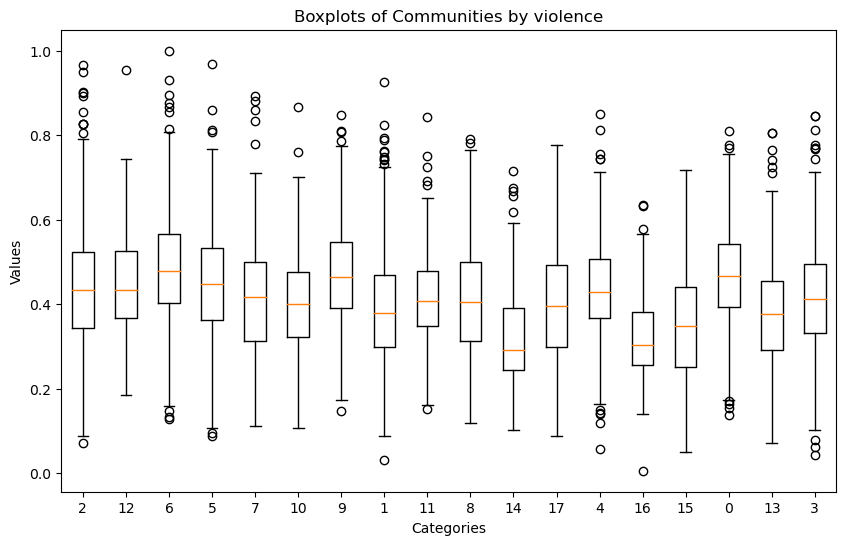

In [61]:
import matplotlib.pyplot as plt

# Prepare figure
# You can adjust the size as needed
y = [info["sentiment_more"][int(i)] for i in sorted_communities_by_year_indexes]
x = sorted_communities_by_year_indexes
boxplot_communities(y,x, 'Boxplots of Communities by violence')

## By Genre

In [62]:
def genre_analysis():
    genres = nx.get_node_attributes(UNDIRECTED_G, "genres")
    nodes_in_genre = [node for node in UNDIRECTED_G if node in genres.keys()]
    flatten_genres = [g  for node in nodes_in_genre for g in genres[node]]
    counts = dict(Counter(flatten_genres))
    # total = sum(counts.values())
    total = len(nodes_in_genre)
    counts = sorted(counts.items(), key=lambda k: k[1], reverse=True)
    counts = [(i, 100*c/total) for i,c in counts]
    return counts, len(nodes_in_genre)
overall_prop, total_games_with_genre = genre_analysis()

In [63]:
from scipy.stats import chi2_contingency

def check_significant_overrepresentation(overall_proportions, community_proportions, total_games):
    significant_genres = []
    # total_games_in_community = sum(c for _,c in overall_proportions)
    for genre, comm_prop in community_proportions:
        overall_prop = next((item[1] for item in overall_proportions if item[0] == genre), None)
        if overall_prop is None:
            continue  # Skip if genre is not found in overall proportions

        # Calculate expected and observed counts
        expected_count = overall_prop * total_games / 100
        observed_count = comm_prop * total_games / 100
        contingency_table = np.array([[observed_count, total_games - observed_count],
                                      [expected_count, total_games - expected_count]])

        # Perform the chi-squared test
        chi2, p_value = chi2_contingency(contingency_table)[:2]

        if p_value < 0.05:  # Consider significance level of 0.05
            if observed_count > expected_count:
                representation = '+++ Overrepresented +++'
            else:
                representation = '--- Underrepresented ---'
            significant_genres.append((genre, comm_prop, 100*(observed_count/expected_count-1), representation))

    return sorted(significant_genres, key=lambda x: x[2], reverse=True)

In [64]:
genre_breakdown = pd.DataFrame(columns=["Community", "Genre", "Presence (%)", "Increase (%)", "Status"])
genres = nx.get_node_attributes(UNDIRECTED_G, "genres")
max_genre_length = max(len(g) for g in genres)
total = 0
for i in range(len(communities)):
    for (g,c,v,r) in significant_genres:
        print(f"\t\t{g.ljust(max_genre_length)}{round(c,2)}%\t{round(v,2)}%\t{r}")
        total += c
        genre_breakdown.loc[len(genre_breakdown)] = {
            "Community": i,
            "Genre": g, 
            "Presence (%)": round(c,2),
            "Increase (%)": round(v,2),
            "Status": r
        }
    

		Non-games                                                                                    0.27%	823.13%	+++ Overrepresented +++
		Music video games                                                                            8.94%	539.09%	+++ Overrepresented +++
		Sandbox games                                                                                0.54%	453.88%	+++ Overrepresented +++
		Party video games                                                                            2.71%	233.66%	+++ Overrepresented +++
		Tactical role-playing video games                                                            5.96%	197.2%	+++ Overrepresented +++
		Action games                                                                                 9.49%	163.39%	+++ Overrepresented +++
		Puzzle video games                                                                           10.03%	152.38%	+++ Overrepresented +++
		Sports video games                                                 

In [65]:
genre_breakdown

,Community,Genre,Presence (%),Increase (%),Status
0,0,Non-games,0.27,823.13,+++ Overrepresented +++
1,0,Music video games,8.94,539.09,+++ Overrepresented +++
2,0,Sandbox games,0.54,453.88,+++ Overrepresented +++
3,0,Party video games,2.71,233.66,+++ Overrepresented +++
4,0,Tactical role-playing video games,5.96,197.20,+++ Overrepresented +++
...,...,...,...,...,...
391,17,Strategy video games,0.54,-48.24,--- Underrepresented ---
392,17,Art games,0.27,-48.72,--- Underrepresented ---
393,17,Eroge,0.27,-51.41,--- Underrepresented ---
394,17,Shooter games,0.27,-53.06,--- Underrepresented ---


In [66]:
genre_breakdown.to_csv('genre_breakdown.csv', index=False)

### Community descriptions

#### Community 0
- **Overrepresented Genres:** Immersive sims, Survival horror video games, Stealth video games, Soulslike video games, Psychological horror games, Neo-noir video games, Open-world video games, Action-adventure games, Survival video games, Art games, Sandbox games, Hack and slash games, Mystery video games, Horror video games, Beat 'em ups, Adventure games.
    - A strong preference for narrative-driven, immersive experiences with a focus on horror, stealth, and open-world adventure.

#### Community 1
- **Overrepresented Genres:** Dress-up video games, Party video games, Educational video games, Pinball video games, Metroidvania games, Puzzle video games, Racing video games, Platformers, Action games, Action-adventure games, Shooter games, Simulation video games, Tactical role-playing video games, Art games, Hack and slash games.
    - Diverse interests ranging from creative and social games like Dress-up and Party games to more action-oriented genres like Racing and Shooter games.

#### Community 2
- **Overrepresented Genres:** Quiz video games, Shooter games, Interactive movie video games, Pinball video games, Educational video games, Racing video games, Action games, Platformers, Puzzle video games, Sports video games, Art games, Party video games, Metroidvania games.
    - A mix of intellectual and interactive genres, suggesting a community that enjoys both knowledge-based challenges and dynamic action games.

#### Community 3
- **Overrepresented Genres:** Social deduction video games, Battle royale games, Roguelike video games, Sandbox games, Construction and management simulation games, Non-games, Survival video games, Vehicle-building video games, Pinball video games, Strategy video games, Neo-noir video games, Simulation video games, Shooter games, Music video games, Metroidvania games, Art games, Open-world video games, Puzzle video games, Action games, Hack and slash games, Beat 'em ups, Stealth video games, Platformers.
    - A highly eclectic mix, indicating a community with varied tastes in gaming, from strategy and simulation to fast-paced action and survival genres.

#### Community 4
- **Overrepresented Genres:** Incremental games, Tactical role-playing video games, Role-playing video games, Mystery video games, Digital tabletop games, Roguelike video games, Simulation video games, Music video games.
    - Shows a preference for gradual progression in Incremental games, strategic depth in Tactical RPGs, and a blend of mystery and music themes.

#### Community 5
- **Overrepresented Genres:** Fighting games, Martial arts video games, Sports video games, Beat 'em ups, Digital tabletop games, Educational video games, Soulslike video games, Hack and slash games, Action games, Platformers, Shooter games, Action-adventure games.
    - Focuses on physical and competitive gaming experiences, with an emphasis on fighting, sports, and action-packed genres.

#### Community 6
- **Overrepresented Genres:** Puzzle video games, Shooter games, Action games, Platformers, Action-adventure games, Beat 'em ups, Racing video games, Party video games, Art games, Metroidvania games.
    - A blend of fast-paced action (Shooter, Beat 'em ups) and thoughtful gameplay (Puzzle, Metroidvania), indicating versatile gaming interests.

#### Community 7
- **Overrepresented Genres:** Soulslike video games, Horror video games, Stealth video games, Shooter games, Psychological horror games, Sandbox games, Action-adventure games, Art games, Open-world video games, Mystery video games, Neo-noir video games, Tactical role-playing video games, Hack and slash games, Beat 'em ups, Fighting games.
    - A strong inclination towards intense and immersive experiences, particularly in the realms of horror, stealth, and action.

#### Community 8
- **Overrepresented Genres:** Racing video games, Vehicle-building video games, Simulation video games, Sandbox games, Open-world video games, Shooter games, Horror video games, Beat 'em ups, Tactical role-playing video games, Action games, Fighting games, Action-adventure games, Stealth video games, Art games, Adventure games.
    - Enjoys a mix of high-speed Racing, in-depth Simulation, and engaging Open-world adventures, along with action-packed Shooter and Fighting games.

#### Community 9
- **Overrepresented Genres:** Shooter games, Fighting games, Stealth video games, Racing video games, Beat 'em ups, Action games, Art games, Mystery video games, Hack and slash games, Action-adventure games, Psychological horror games, Horror video games, Tactical role-playing video games.
    - Prefers action and adventure with a blend of Shooter, Fighting, and Stealth games, complemented by Horror and Mystery genres for narrative depth.

#### Community 10
- **Overrepresented Genres:** Music video games, Puzzle video games, Shooter games, Racing video games, Beat 'em ups, Art games, Action games, Hack and slash games, Platformers, Fighting games, Action-adventure games.
    - Shows a balance between rhythm-based Music games and high-energy genres like Racing and Shooter games, with a touch of Puzzle and Platformer elements.

#### Community 11
- **Overrepresented Genres:** Role-playing video games, Simulation video games, Incremental games, Construction and management simulation games, Tactical role-playing video games, Sandbox games, Open-world video games, Strategy video games, Immersive sims, Adventure games.
    - A preference for complex and strategic gaming experiences in RPGs and Simulation genres, indicating a taste for depth and narrative.

#### Community 12
- **Overrepresented Genres:** Non-games, Digital tabletop games, Typing video games, Educational video games, Metroidvania games, Platformers, Action games, Strategy video games, Tactical role-playing video games, Hack and slash games.
    - Enjoys a variety of genres from educational and strategy-based games to more dynamic action-oriented experiences.

#### Community 13
- **Overrepresented Genres:** Eroge, Typing video games, Construction and management simulation games, Music video games, Hack and slash games, Tactical role-playing video games, Mystery video games, Beat 'em ups, Shooter games, Fighting games, Role-playing video games.
    - Diverse interests with a mix of adult-themed Eroge, rhythm-based Music games, and a range of action-packed genres like Hack and slash, and Shooter games.

#### Community 14
- **Overrepresented Genres:** Racing video games, Open-world video games, Martial arts video games, Simulation video games, Metroidvania games, Beat 'em ups.
    - A strong preference for dynamic and immersive experiences, particularly in Racing and Open-world games, with an interest in combat-oriented genres.

#### Community 15
- **Overrepresented Genres:** Incremental games, Interactive movie video games, Puzzle video games, Strategy video games, Simulation video games, Shooter games, Art games, Music video games, Action games, Role-playing video games, Open-world video games, Hack and slash games.
    - Enjoys a combination of thought-provoking Strategy and Simulation games with more action-focused Shooter and Hack and slash genres.

#### Community 16
- **Overrepresented Genres:** Music video games, Puzzle video games, Racing video games, Party video games, Fighting games.
    - A blend of rhythm and strategy with Music and Puzzle games, alongside fast-paced Racing and Fighting games for a dynamic gaming experience.

#### Community 17
- **Overrepresented Genres:** Non-games, Music video games, Sandbox games, Party video games, Tactical role-playing video games, Action games, Puzzle video games, Sports video games, Action-adventure games, Hack and slash games, Horror video games, Beat 'em ups, Open-world video games.
    - A diverse range of interests from rhythm and strategy in Music and Puzzle games to action-oriented genres like Sports, Action-adventure, and Hack and slash games.
